In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery as bq

%matplotlib inline

In [2]:
hormone_expression_bigtable = pd.read_table("./datasets/hormone_expression_bigtable.IlluminaHiSeq.tsv", sep="\t")
print(hormone_expression_bigtable.shape)
hormone_expression_bigtable.head()

(115136, 19)


/home/singuyen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,case_barcode,sample_barcode,aliquot_barcode,gene_symbol,normalized_count,transformed_count,sample_type,sample_type_name,initial_response,recurrence_status,recurrence_log,subtype,ER,PR,Her2_IHC,Her2_ISH,Her2,triple_negative,subtype_sub
0,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,A1CF,0.0000,0.000000,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA
1,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,AATK,54.5535,5.795806,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA
2,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,ADRA2C,39.8885,5.353623,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA
3,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,ANP32E,766.0947,9.583261,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA
4,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,ARHGEF37,1644.2294,10.684073,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA


In [3]:
print("Sample types")
print(hormone_expression_bigtable.drop_duplicates(subset="sample_barcode").sample_type_name.value_counts())
print("\n")

print("Cases - Initial responses")
print(hormone_expression_bigtable.drop_duplicates(subset="case_barcode").initial_response.value_counts())
print("\n")

print("Cases - Recurrence status")
print(hormone_expression_bigtable.drop_duplicates(subset="case_barcode").recurrence_status.value_counts())
print("\n")

print("Cases - Recurrence log")
print(hormone_expression_bigtable.drop_duplicates(subset="case_barcode").recurrence_log.value_counts())
print("\n")

Sample types
Primary solid Tumor    480
Solid Tissue Normal     33
Metastatic               1
Name: sample_type_name, dtype: int64


Cases - Initial responses
Unknown               431
Complete response      40
Progressive/Stable      9
Name: initial_response, dtype: int64


Cases - Recurrence status
Unknown     423
Occured      42
Low risk      8
Name: recurrence_status, dtype: int64


Cases - Recurrence log
Alive tumor free, last follow-up within risky period             376
New tumor after/during treatment                                  30
Drug start and end dates unknown                                  18
Dead with tumor                                                   12
Unknown neoplasm status                                           10
Dead tumor free during risky period                                9
Alive tumor free after risky period                                8
Reported having tumor during follow-up but unknown recurrence      8
Alive tumor free but unknown follow

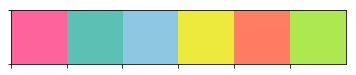

In [4]:
sns.palplot(sns.color_palette(["#ff639c", "#5bc1b5", "#8cc8e2", "#edea3d", "#ff7e63", "#aee851"]))

In [5]:
hormone_expression_bigtable.drop_duplicates(subset="aliquot_barcode")['sample_type_name'].unique()

array(['Primary solid Tumor', 'Solid Tissue Normal', 'Metastatic'],
      dtype=object)

In [6]:
hormone_expression_bigtable.drop_duplicates(subset="aliquot_barcode")['initial_response'].unique()

array(['Unknown', 'Complete response', 'Progressive/Stable'], dtype=object)

In [7]:
hormone_expression_bigtable.drop_duplicates(subset="aliquot_barcode")['recurrence_status'].unique()

array([nan, 'Unknown', 'Low risk', 'Occured'], dtype=object)

# Include normal
## Initial response

In [8]:
init_res = hormone_expression_bigtable.loc[hormone_expression_bigtable['initial_response'] != 'Unknown']
expression_matrix = init_res.pivot(index='gene_symbol', columns='aliquot_barcode', values='transformed_count')

print(expression_matrix.shape)
expression_matrix.head()

(224, 53)


aliquot_barcode,TCGA-A2-A0CO-01A-13R-A22K-07,TCGA-A2-A0CR-01A-11R-A22K-07,TCGA-A2-A0EP-01A-52R-A22U-07,TCGA-A2-A0EW-01A-21R-A115-07,TCGA-A2-A3Y0-01A-11R-A239-07,TCGA-A7-A3RF-01A-11R-A22K-07,TCGA-A7-A5ZX-01A-12R-A29R-07,TCGA-A8-A06R-01A-11R-A00Z-07,TCGA-A8-A07I-01A-11R-A00Z-07,TCGA-A8-A082-01A-11R-A00Z-07,...,TCGA-GM-A3XG-01A-31R-A24H-07,TCGA-GM-A3XN-01A-12R-A22U-07,TCGA-GM-A5PX-01A-12R-A28M-07,TCGA-LL-A50Y-01A-11R-A266-07,TCGA-LL-A73Z-01A-11R-A32P-07,TCGA-OL-A5S0-01A-11R-A28M-07,TCGA-S3-A6ZG-01A-22R-A32P-07,TCGA-S3-AA11-01A-31R-A41B-07,TCGA-V7-A7HQ-01A-11R-A33J-07,TCGA-WT-AB41-01A-11R-A41B-07
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,0.000000,0.000000,0.000000,0.000000,0.409690,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.760434,0.000000,0.000000,0.000000,0.545079,0.000000,0.952706,0.000000,0.000000,0.000000
AATK,8.486223,6.383497,5.767877,4.875254,5.660535,9.790787,6.667679,6.363222,4.994018,8.014578,...,6.911355,8.201979,7.081377,7.122937,6.127749,5.733663,4.921884,4.922212,6.748976,6.290703
ADRA2C,7.371518,7.262014,7.054130,6.048299,3.039805,7.731880,5.561949,7.884440,6.450045,8.328226,...,6.034394,6.992436,7.017541,4.633699,6.362245,5.938330,3.235696,6.970269,7.721103,9.522046
ANP32E,9.561221,9.829963,10.097180,9.781118,11.297024,8.128950,9.683484,8.871398,10.166508,9.805744,...,9.591270,10.365569,9.911534,9.741722,10.626102,10.873870,10.839075,9.483399,8.734465,10.252020
ARHGEF37,9.595124,9.264392,8.485730,10.890471,7.813378,9.261242,10.166972,9.362138,9.839904,9.551131,...,10.299556,9.696275,9.071271,9.657298,10.149730,8.431245,9.445090,10.271471,9.442248,6.415909


In [9]:
color_matrix = pd.DataFrame()
df = init_res.drop_duplicates(subset="aliquot_barcode")

print(print(df['sample_type_name'].unique()))
print(df['initial_response'].unique())

['Primary solid Tumor' 'Solid Tissue Normal']
None
['Complete response' 'Progressive/Stable']


In [10]:
c = dict(zip(df['sample_type_name'].unique(), ["#ff639c", "#5bc1b5"]))
color_matrix['Sample types'] = df['sample_type_name'].map(c)

c = dict(zip(df['initial_response'].unique(), ["#8cc8e2", "#edea3d"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Sample types,Initial response
aliquot_barcode,,
TCGA-A2-A0CO-01A-13R-A22K-07,#ff639c,#8cc8e2
TCGA-A2-A0CR-01A-11R-A22K-07,#ff639c,#8cc8e2
TCGA-A2-A0EP-01A-52R-A22U-07,#ff639c,#8cc8e2
TCGA-A2-A0EW-01A-21R-A115-07,#ff639c,#edea3d
TCGA-A2-A3Y0-01A-11R-A239-07,#ff639c,#8cc8e2


In [11]:
distance = scipy.spatial.distance.squareform(1-expression_matrix.corr())
linkage = scipy.cluster.hierarchy.linkage(distance, method='weighted')

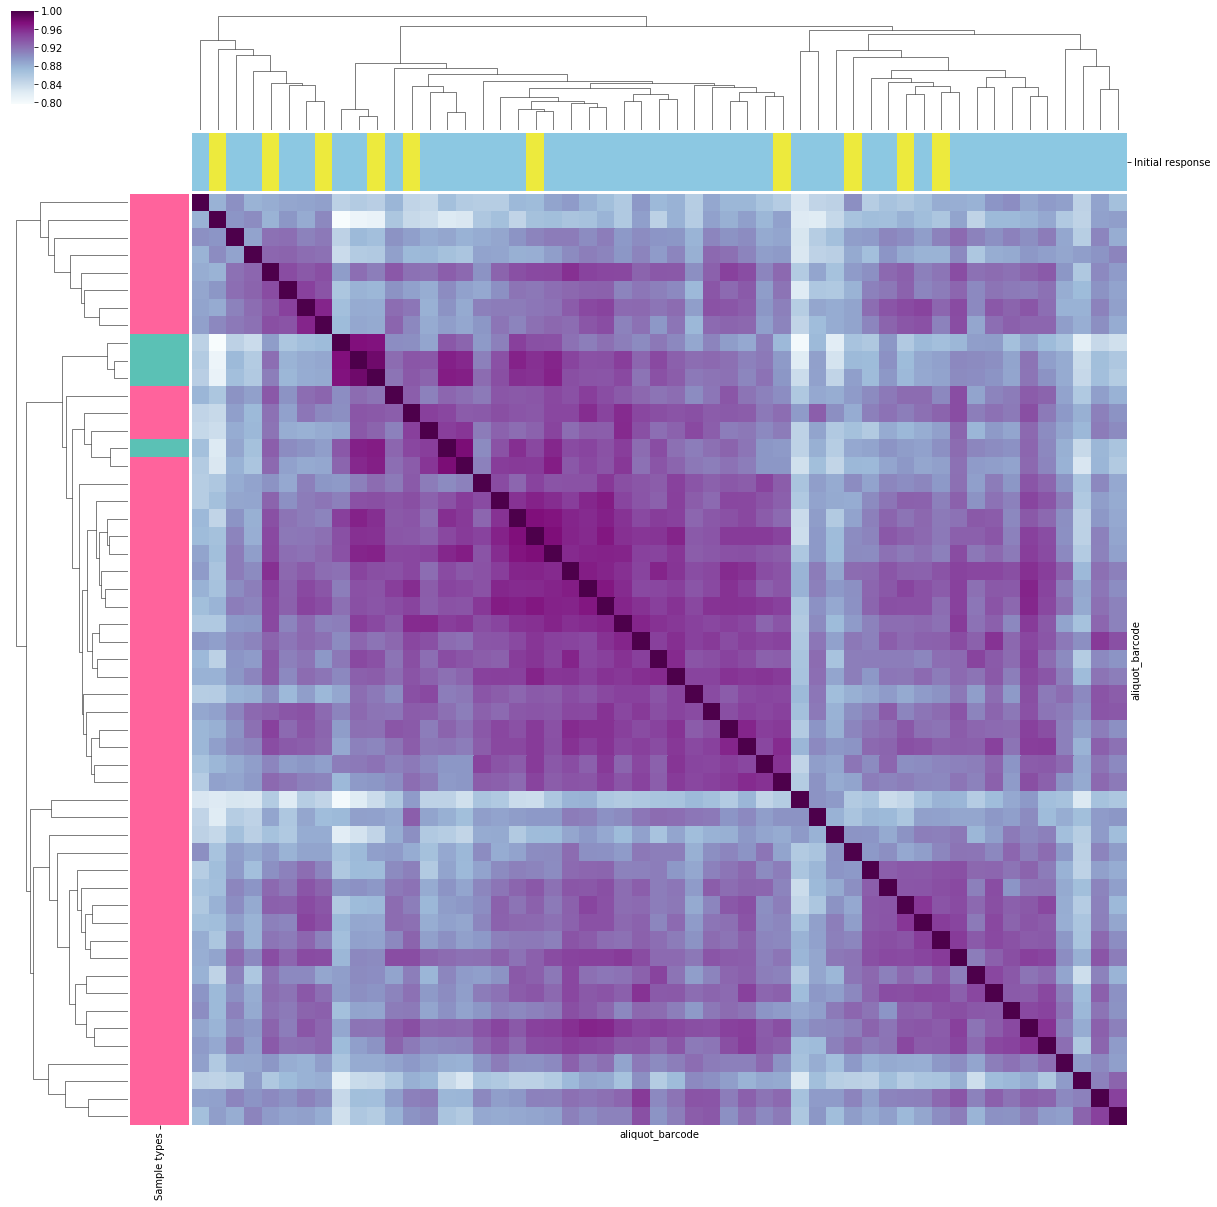

In [12]:
g = sns.clustermap(data=expression_matrix.corr(), col_linkage=linkage, row_linkage=linkage,
                   row_colors=color_matrix['Sample types'], col_colors = color_matrix.iloc[:,1:],
                   cmap="BuPu", vmax=1, figsize=(20,20.5), 
                   xticklabels=False, yticklabels=False)

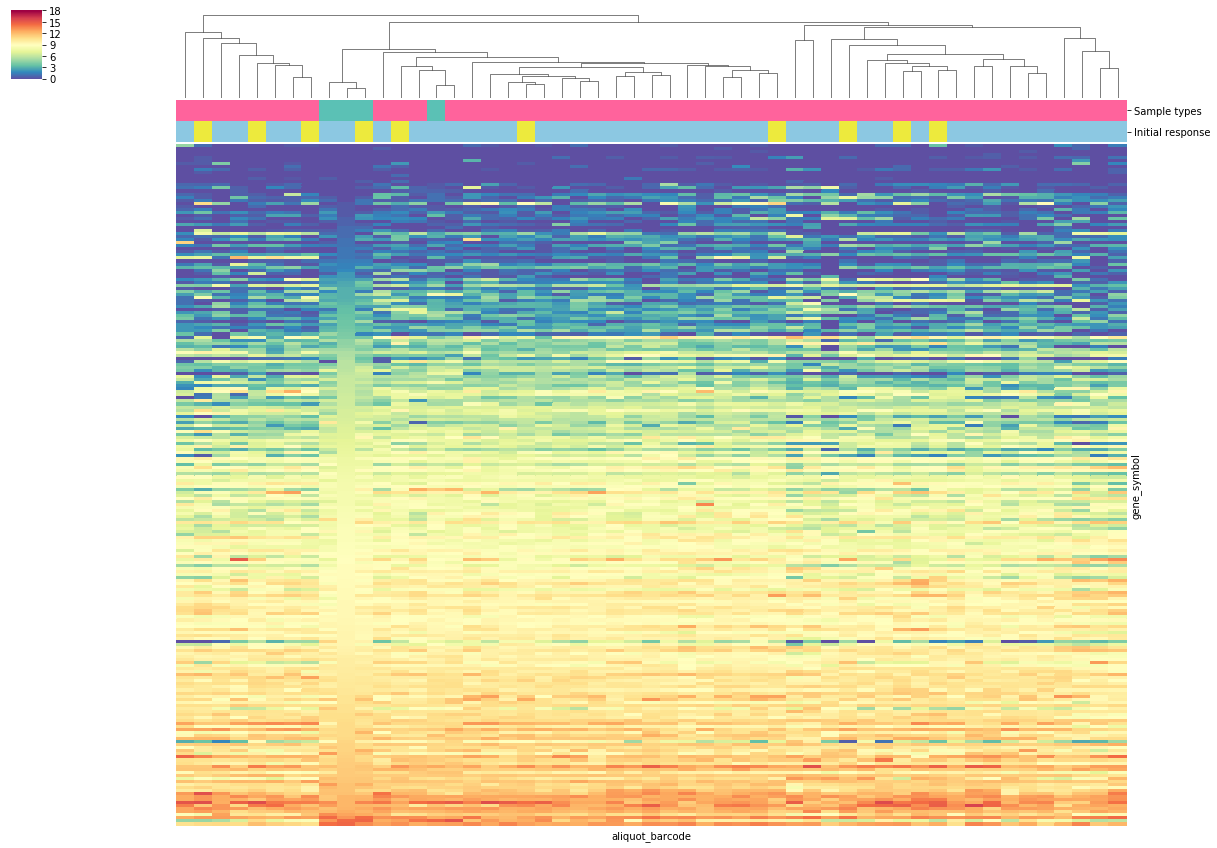

In [13]:
normal_aliquots = init_res.loc[(init_res['sample_type'] == 11), 'aliquot_barcode'].unique()

g1 = sns.clustermap(data=expression_matrix.sort_values(by=list(normal_aliquots)), 
                    col_linkage=linkage, row_cluster = False,
                    col_colors = color_matrix,
                    cmap="Spectral_r", vmin=0, vmax=18, figsize=(20,15), 
                    xticklabels=False, yticklabels=False)

In [14]:
g.savefig("./plots/cluster_expression.hormone.init_res.corrdata.png")
g1.savefig("./plots/cluster_expression.hormone.init_res.expressiondata.png")

## Recurrence status

In [15]:
recur = hormone_expression_bigtable.loc[(hormone_expression_bigtable['recurrence_status'] != 'Unknown') & 
                                     (hormone_expression_bigtable['recurrence_status'].isna() == False)]
expression_matrix = recur.pivot(index='gene_symbol', columns='aliquot_barcode', values='transformed_count')

print(expression_matrix.shape)
expression_matrix.head()

(224, 54)


aliquot_barcode,TCGA-A2-A04N-01A-11R-A115-07,TCGA-A2-A04V-01A-21R-A034-07,TCGA-A2-A0CK-01A-11R-A22K-07,TCGA-A2-A0EW-01A-21R-A115-07,TCGA-A2-A0SV-01A-11R-A084-07,TCGA-A2-A0SW-01A-11R-A084-07,TCGA-A2-A0YC-01A-11R-A109-07,TCGA-A2-A25B-01A-11R-A169-07,TCGA-A2-A25E-01A-11R-A169-07,TCGA-A7-A13E-01A-11R-A12P-07,...,TCGA-E9-A1NF-01A-11R-A14D-07,TCGA-E9-A1NF-11A-73R-A14D-07,TCGA-EW-A1P0-01A-11R-A144-07,TCGA-GM-A2D9-01A-11R-A18M-07,TCGA-GM-A2DA-01A-11R-A18M-07,TCGA-GM-A2DC-01A-11R-A18M-07,TCGA-GM-A2DM-01A-11R-A180-07,TCGA-GM-A2DN-01A-11R-A180-07,TCGA-LL-A73Z-01A-11R-A32P-07,TCGA-LQ-A4E4-01A-11R-A266-07
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.427070,0.394514,0.512985,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.629566,0.000000,0.000000,0.545079,0.000000
AATK,6.215220,7.098839,8.701945,4.875254,5.460752,5.173851,6.156443,3.316377,5.618315,5.894898,...,4.616346,5.932904,5.648207,6.821139,4.572968,8.295913,8.713732,6.371308,6.127749,4.854415
ADRA2C,5.412802,4.444813,6.541038,6.048299,6.377509,3.352377,3.563158,2.848358,4.918639,1.832769,...,5.299666,6.964089,3.756084,6.580773,5.816973,9.217166,1.732313,4.037918,6.362245,6.689829
ANP32E,9.372962,10.669437,10.030458,9.781118,9.562843,9.542102,10.799081,11.367194,11.081927,11.732477,...,9.698123,9.802101,7.684026,9.453122,9.661606,10.929548,9.665320,10.816003,10.626102,9.658979
ARHGEF37,9.882563,9.060422,8.109316,10.890471,8.890091,8.301803,5.532108,7.773157,8.697492,10.296142,...,9.299344,8.928484,9.166732,9.187520,9.310825,9.816281,9.523792,9.118826,10.149730,10.343930


In [16]:
color_matrix = pd.DataFrame()
df = recur.drop_duplicates(subset="aliquot_barcode")

print(print(df['sample_type_name'].unique()))
print(df['recurrence_status'].unique())

['Primary solid Tumor' 'Solid Tissue Normal']
None
['Low risk' 'Occured']


In [17]:
c = dict(zip(df['sample_type_name'].unique(), ["#ff639c", "#5bc1b5"]))
color_matrix['Sample types'] = df['sample_type_name'].map(c)

c = dict(zip(df['recurrence_status'].unique(), ["#aee851", "#ff7e63"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Sample types,Recurrence status
aliquot_barcode,,
TCGA-A2-A04N-01A-11R-A115-07,#ff639c,#aee851
TCGA-A2-A04V-01A-21R-A034-07,#ff639c,#ff7e63
TCGA-A2-A0CK-01A-11R-A22K-07,#ff639c,#ff7e63
TCGA-A2-A0EW-01A-21R-A115-07,#ff639c,#ff7e63
TCGA-A2-A0SV-01A-11R-A084-07,#ff639c,#ff7e63


In [18]:
distance = scipy.spatial.distance.squareform(1-expression_matrix.corr())
linkage = scipy.cluster.hierarchy.linkage(distance, method='weighted')

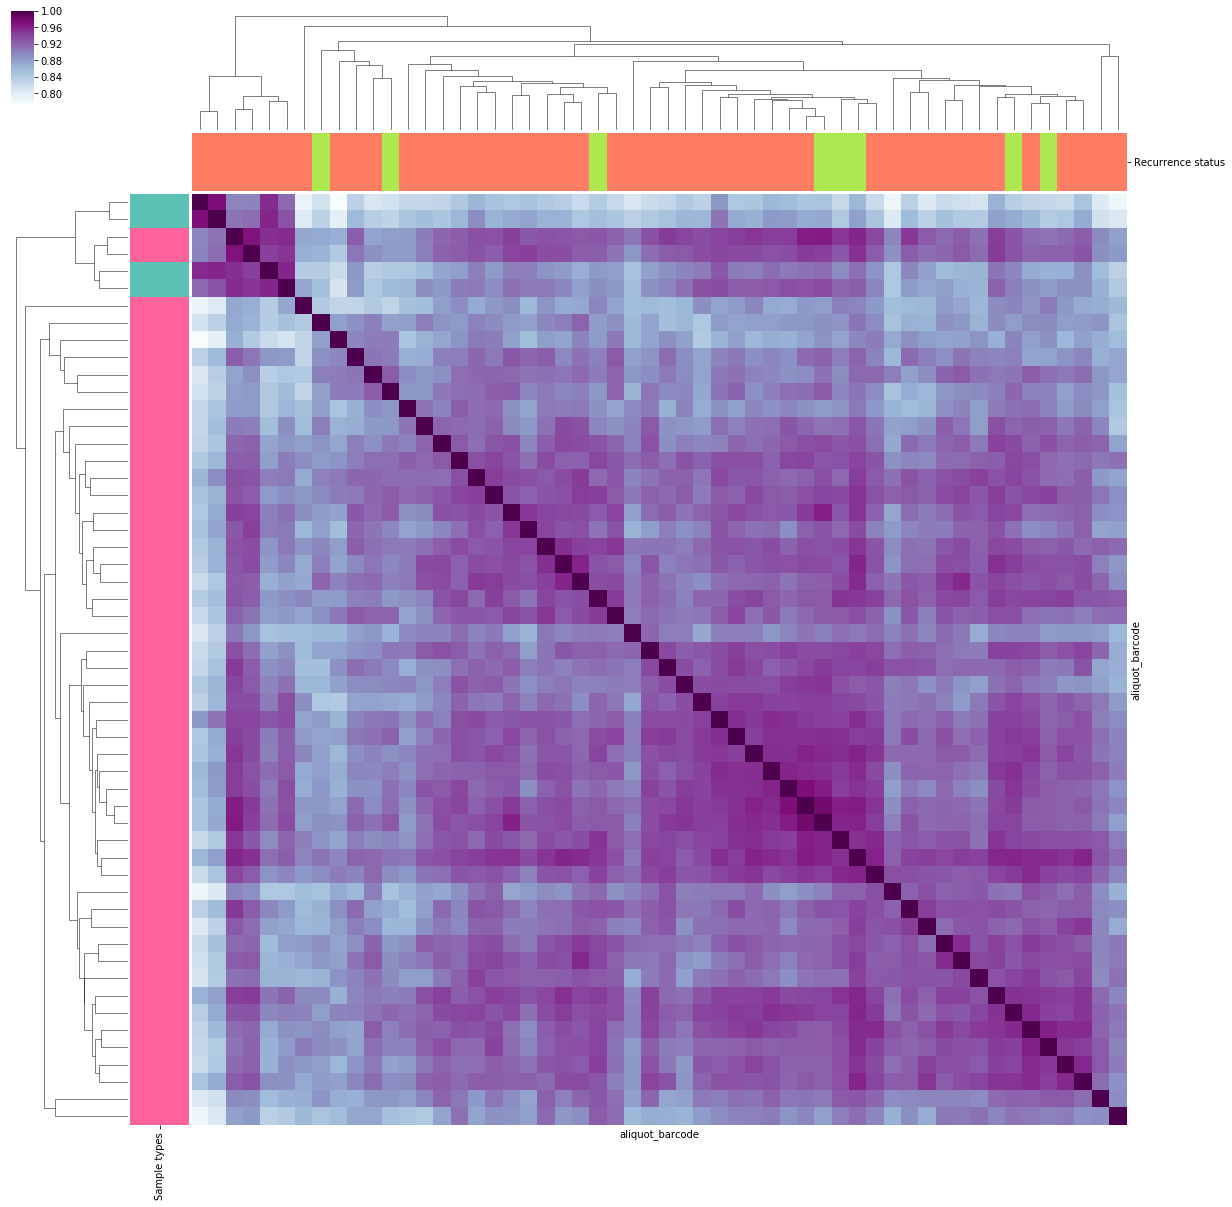

In [19]:
g2 = sns.clustermap(data=expression_matrix.corr(), col_linkage=linkage, row_linkage=linkage,
                   row_colors=color_matrix['Sample types'], col_colors = color_matrix.iloc[:,1:],
                   cmap="BuPu", vmax=1, figsize=(20,20.5), 
                   xticklabels=False, yticklabels=False)

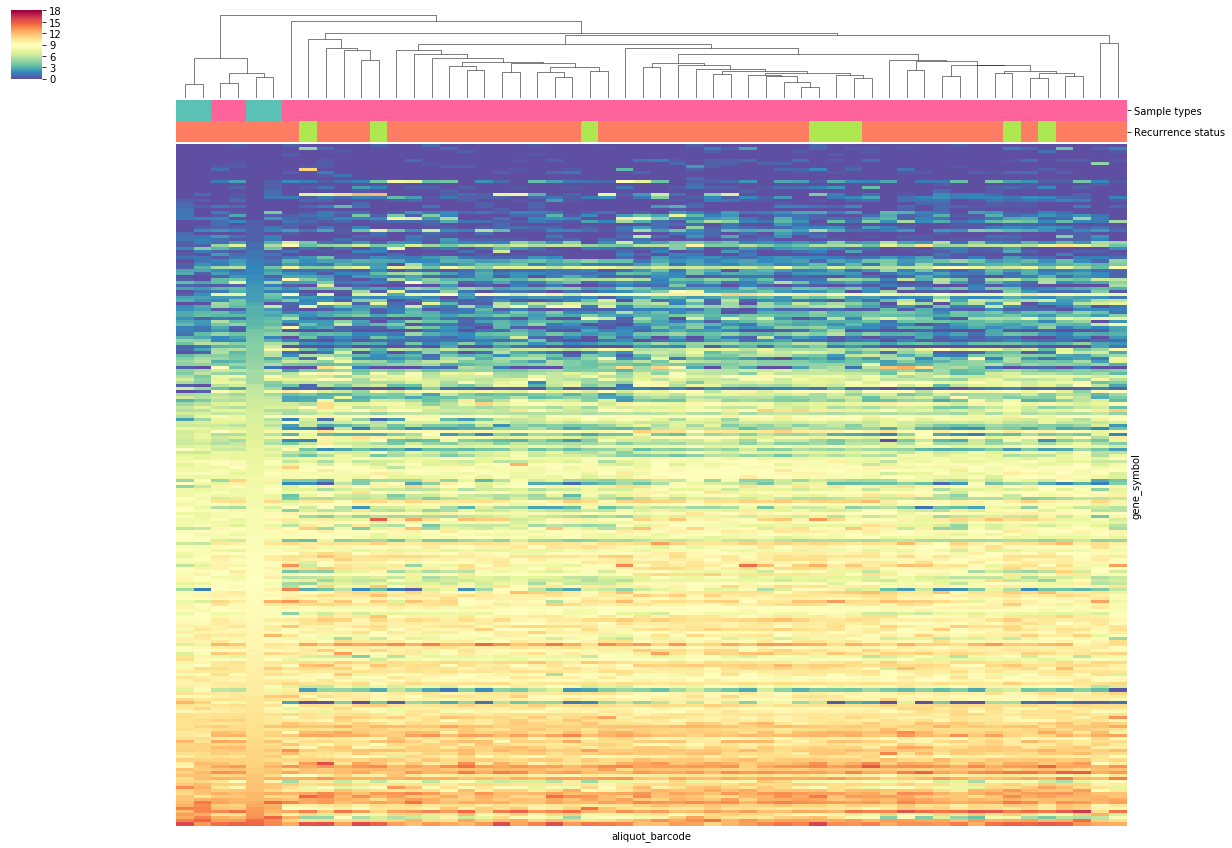

In [20]:
normal_aliquots = recur.loc[(recur['sample_type'] == 11), 'aliquot_barcode'].unique()

g3 = sns.clustermap(data=expression_matrix.sort_values(by=list(normal_aliquots)), 
                    col_linkage=linkage, row_cluster = False,
                    col_colors = color_matrix,
                    cmap="Spectral_r", vmin=0, vmax=18, figsize=(20,15), 
                    xticklabels=False, yticklabels=False)

In [21]:
g2.savefig("./plots/cluster_expression.hormone.recur.corrdata.png")
g3.savefig("./plots/cluster_expression.hormone.recur.expressiondata.png")

# Exclude normal
## Initial response

In [8]:
init_res = hormone_expression_bigtable.loc[(hormone_expression_bigtable['sample_type'] == 1) & 
                                     (hormone_expression_bigtable['initial_response'] != 'Unknown')]
expression_matrix = init_res.pivot(index='gene_symbol', columns='aliquot_barcode', values='transformed_count')

print(expression_matrix.shape)
expression_matrix.head()

(224, 49)


aliquot_barcode,TCGA-A2-A0CO-01A-13R-A22K-07,TCGA-A2-A0CR-01A-11R-A22K-07,TCGA-A2-A0EP-01A-52R-A22U-07,TCGA-A2-A0EW-01A-21R-A115-07,TCGA-A2-A3Y0-01A-11R-A239-07,TCGA-A7-A3RF-01A-11R-A22K-07,TCGA-A7-A5ZX-01A-12R-A29R-07,TCGA-A8-A06R-01A-11R-A00Z-07,TCGA-A8-A07I-01A-11R-A00Z-07,TCGA-A8-A082-01A-11R-A00Z-07,...,TCGA-GM-A3XG-01A-31R-A24H-07,TCGA-GM-A3XN-01A-12R-A22U-07,TCGA-GM-A5PX-01A-12R-A28M-07,TCGA-LL-A50Y-01A-11R-A266-07,TCGA-LL-A73Z-01A-11R-A32P-07,TCGA-OL-A5S0-01A-11R-A28M-07,TCGA-S3-A6ZG-01A-22R-A32P-07,TCGA-S3-AA11-01A-31R-A41B-07,TCGA-V7-A7HQ-01A-11R-A33J-07,TCGA-WT-AB41-01A-11R-A41B-07
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,0.000000,0.000000,0.000000,0.000000,0.409690,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.760434,0.000000,0.000000,0.000000,0.545079,0.000000,0.952706,0.000000,0.000000,0.000000
AATK,8.486223,6.383497,5.767877,4.875254,5.660535,9.790787,6.667679,6.363222,4.994018,8.014578,...,6.911355,8.201979,7.081377,7.122937,6.127749,5.733663,4.921884,4.922212,6.748976,6.290703
ADRA2C,7.371518,7.262014,7.054130,6.048299,3.039805,7.731880,5.561949,7.884440,6.450045,8.328226,...,6.034394,6.992436,7.017541,4.633699,6.362245,5.938330,3.235696,6.970269,7.721103,9.522046
ANP32E,9.561221,9.829963,10.097180,9.781118,11.297024,8.128950,9.683484,8.871398,10.166508,9.805744,...,9.591270,10.365569,9.911534,9.741722,10.626102,10.873870,10.839075,9.483399,8.734465,10.252020
ARHGEF37,9.595124,9.264392,8.485730,10.890471,7.813378,9.261242,10.166972,9.362138,9.839904,9.551131,...,10.299556,9.696275,9.071271,9.657298,10.149730,8.431245,9.445090,10.271471,9.442248,6.415909


In [9]:
color_matrix = pd.DataFrame()
df = init_res.drop_duplicates(subset="aliquot_barcode")

print(df['initial_response'].unique())

['Complete response' 'Progressive/Stable']


In [10]:
c = dict(zip(df['initial_response'].unique(), ["#8cc8e2", "#edea3d"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Initial response
aliquot_barcode,
TCGA-A2-A0CO-01A-13R-A22K-07,#8cc8e2
TCGA-A2-A0CR-01A-11R-A22K-07,#8cc8e2
TCGA-A2-A0EP-01A-52R-A22U-07,#8cc8e2
TCGA-A2-A0EW-01A-21R-A115-07,#edea3d
TCGA-A2-A3Y0-01A-11R-A239-07,#8cc8e2


In [11]:
distance = scipy.spatial.distance.squareform(1-expression_matrix.corr())
linkage = scipy.cluster.hierarchy.linkage(distance, method='complete')

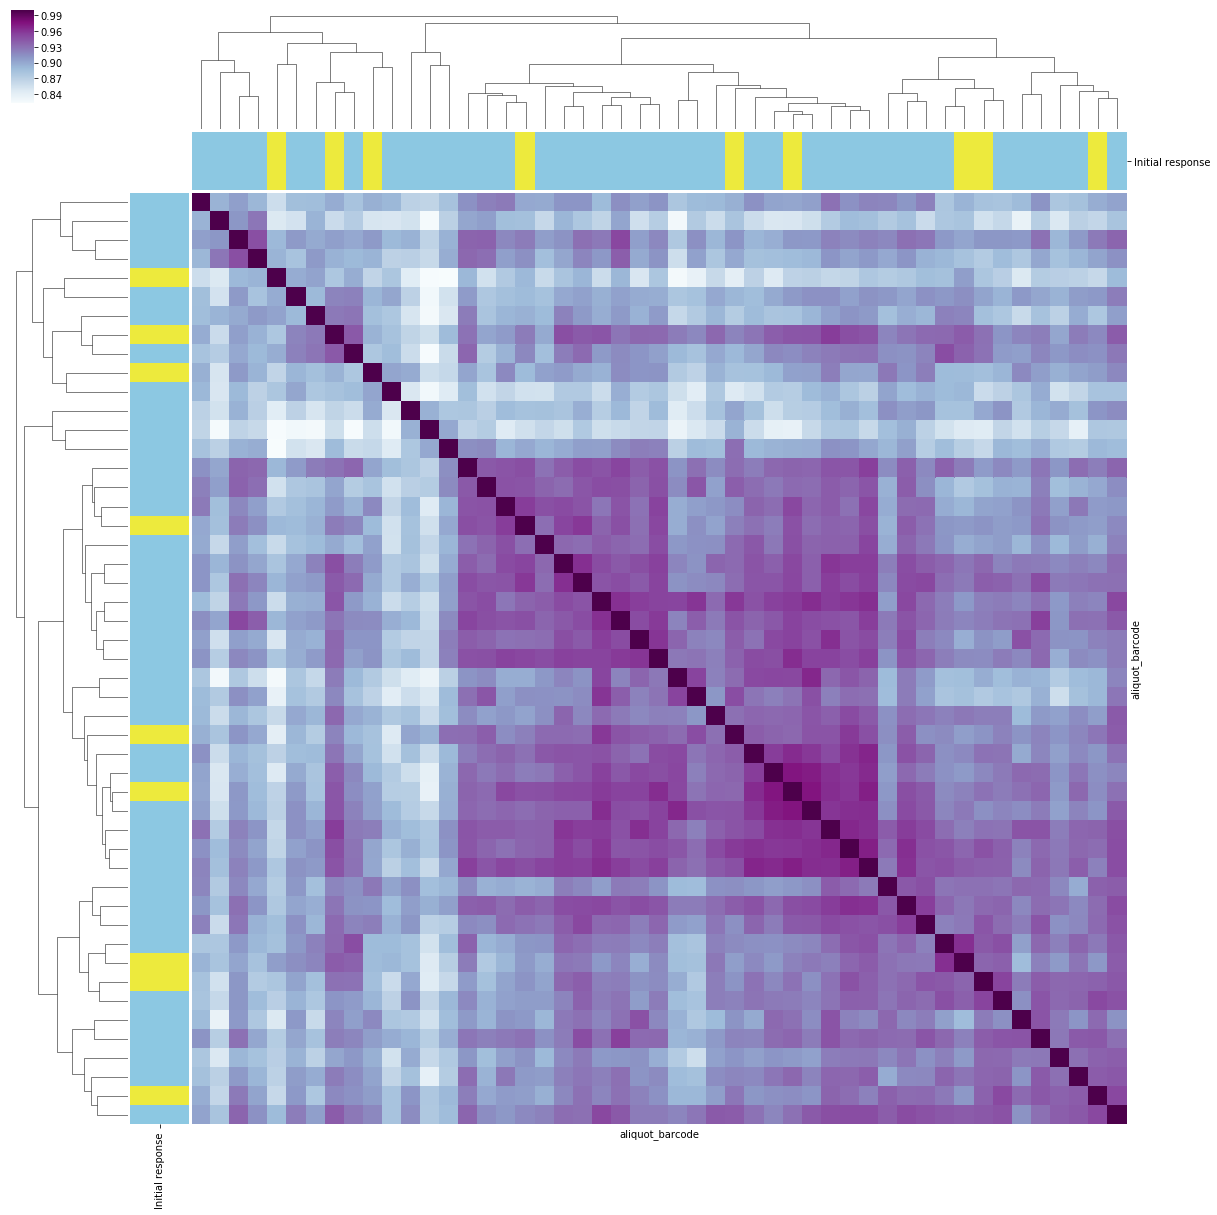

In [12]:
g4 = sns.clustermap(data=expression_matrix.corr(), col_linkage=linkage, row_linkage=linkage,
                   row_colors=color_matrix, col_colors = color_matrix,
                   cmap="BuPu", vmax=1, figsize=(20,20.5), 
                   xticklabels=False, yticklabels=False)

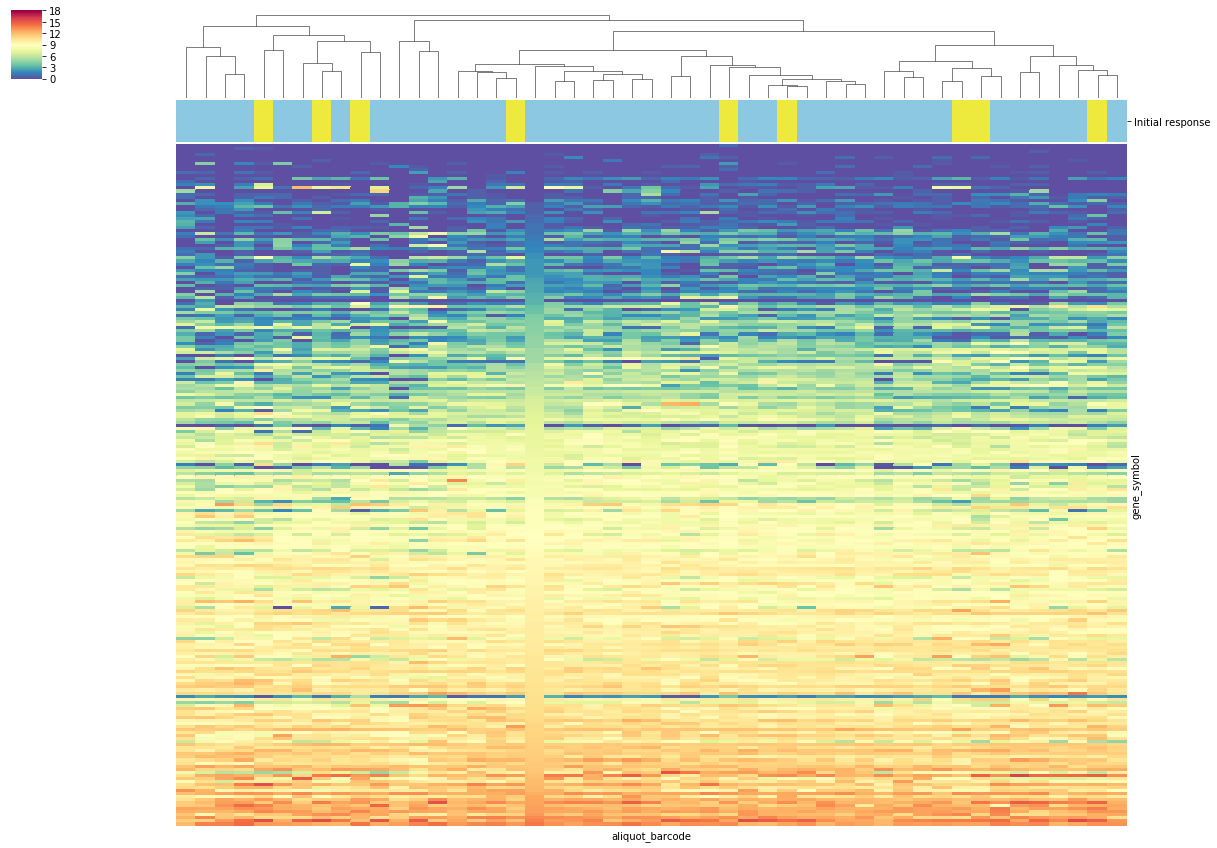

In [13]:
complete_aliquots = init_res.loc[(init_res['initial_response'] == 'Complete response'), 'aliquot_barcode'].unique()

g5 = sns.clustermap(data=expression_matrix.sort_values(by=list(complete_aliquots)), 
                    col_linkage=linkage, row_cluster = False,
                    col_colors = color_matrix,
                    cmap="Spectral_r", vmin=0, vmax=18, figsize=(20,15), 
                    xticklabels=False, yticklabels=False)

In [14]:
g4.savefig("./plots/cluster_expression.hormone.excl_norm.init_res.corrdata.png")
g5.savefig("./plots/cluster_expression.hormone.excl_norm.init_res.expressiondata.png")

## Recurrence status

In [15]:
recur = hormone_expression_bigtable.loc[(hormone_expression_bigtable['sample_type'] == 1) & 
                                  (hormone_expression_bigtable['recurrence_status'] != 'Unknown') & 
                                  (hormone_expression_bigtable['recurrence_status'].isna() == False)]
expression_matrix = recur.pivot(index='gene_symbol', columns='aliquot_barcode', values='transformed_count')

print(expression_matrix.shape)
expression_matrix.head()

(224, 50)


aliquot_barcode,TCGA-A2-A04N-01A-11R-A115-07,TCGA-A2-A04V-01A-21R-A034-07,TCGA-A2-A0CK-01A-11R-A22K-07,TCGA-A2-A0EW-01A-21R-A115-07,TCGA-A2-A0SV-01A-11R-A084-07,TCGA-A2-A0SW-01A-11R-A084-07,TCGA-A2-A0YC-01A-11R-A109-07,TCGA-A2-A25B-01A-11R-A169-07,TCGA-A2-A25E-01A-11R-A169-07,TCGA-A7-A13E-01A-11R-A12P-07,...,TCGA-E9-A1N6-01A-11R-A144-07,TCGA-E9-A1NF-01A-11R-A14D-07,TCGA-EW-A1P0-01A-11R-A144-07,TCGA-GM-A2D9-01A-11R-A18M-07,TCGA-GM-A2DA-01A-11R-A18M-07,TCGA-GM-A2DC-01A-11R-A18M-07,TCGA-GM-A2DM-01A-11R-A180-07,TCGA-GM-A2DN-01A-11R-A180-07,TCGA-LL-A73Z-01A-11R-A32P-07,TCGA-LQ-A4E4-01A-11R-A266-07
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.427070,0.394514,0.512985,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.629566,0.000000,0.000000,0.545079,0.000000
AATK,6.215220,7.098839,8.701945,4.875254,5.460752,5.173851,6.156443,3.316377,5.618315,5.894898,...,5.249999,4.616346,5.648207,6.821139,4.572968,8.295913,8.713732,6.371308,6.127749,4.854415
ADRA2C,5.412802,4.444813,6.541038,6.048299,6.377509,3.352377,3.563158,2.848358,4.918639,1.832769,...,4.355961,5.299666,3.756084,6.580773,5.816973,9.217166,1.732313,4.037918,6.362245,6.689829
ANP32E,9.372962,10.669437,10.030458,9.781118,9.562843,9.542102,10.799081,11.367194,11.081927,11.732477,...,10.063238,9.698123,7.684026,9.453122,9.661606,10.929548,9.665320,10.816003,10.626102,9.658979
ARHGEF37,9.882563,9.060422,8.109316,10.890471,8.890091,8.301803,5.532108,7.773157,8.697492,10.296142,...,10.430058,9.299344,9.166732,9.187520,9.310825,9.816281,9.523792,9.118826,10.149730,10.343930


In [16]:
color_matrix = pd.DataFrame()
df = recur.drop_duplicates(subset="aliquot_barcode")

print(df['recurrence_status'].unique())

['Low risk' 'Occured']


In [17]:
c = dict(zip(df['recurrence_status'].unique(), ["#aee851", "#ff7e63"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Recurrence status
aliquot_barcode,
TCGA-A2-A04N-01A-11R-A115-07,#aee851
TCGA-A2-A04V-01A-21R-A034-07,#ff7e63
TCGA-A2-A0CK-01A-11R-A22K-07,#ff7e63
TCGA-A2-A0EW-01A-21R-A115-07,#ff7e63
TCGA-A2-A0SV-01A-11R-A084-07,#ff7e63


In [18]:
distance = scipy.spatial.distance.squareform(1-expression_matrix.corr())
linkage = scipy.cluster.hierarchy.linkage(distance, method='complete')

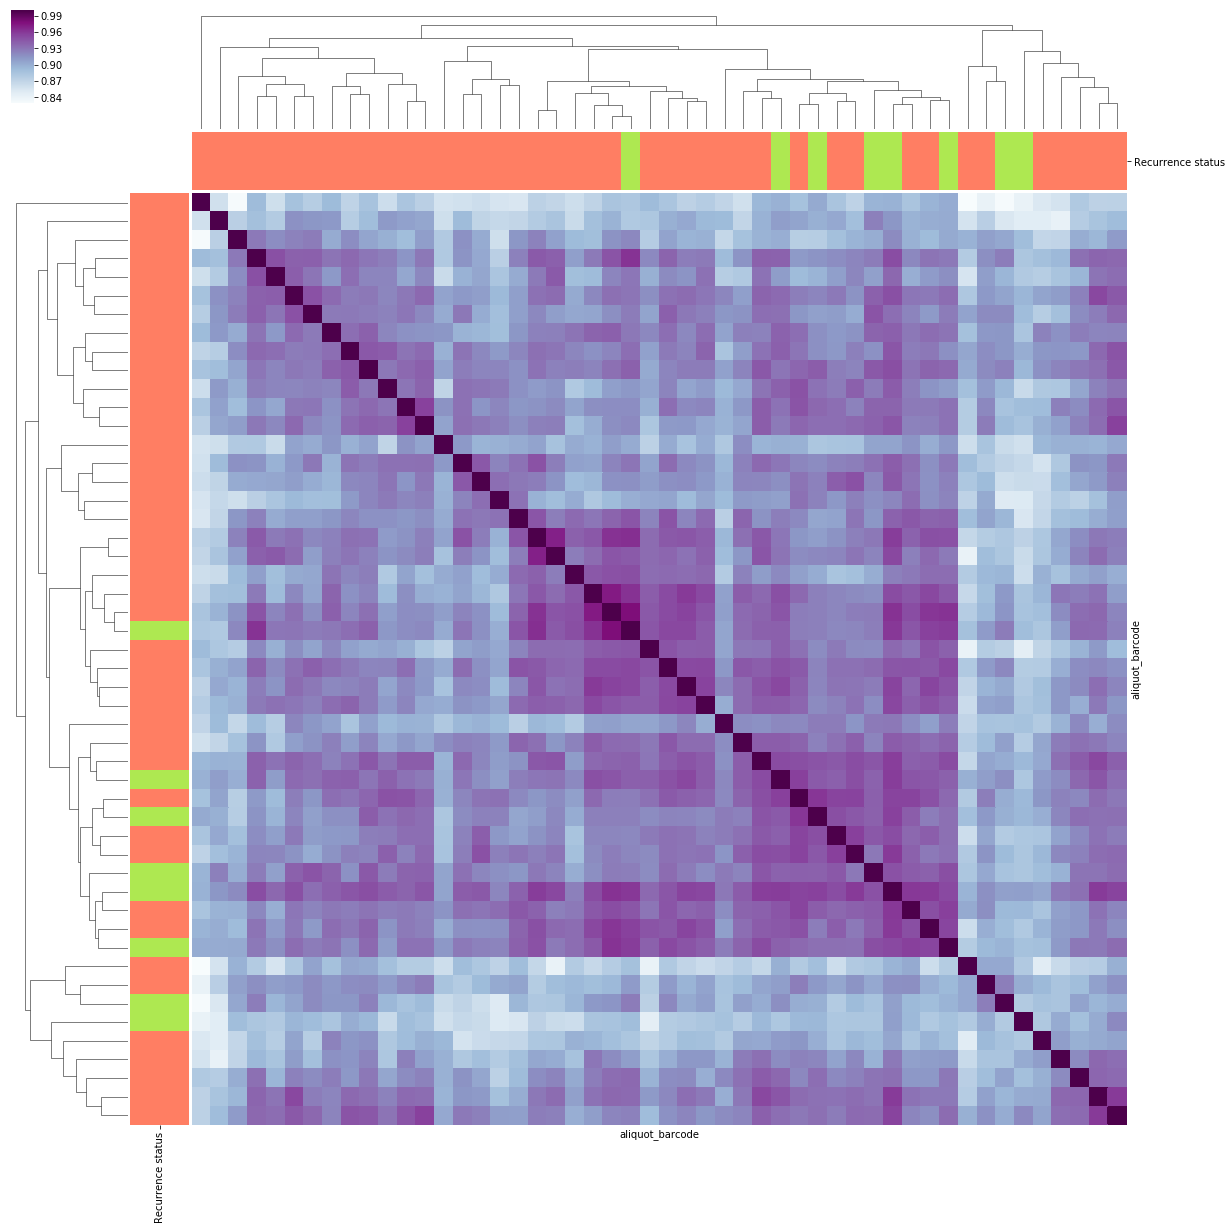

In [19]:
g6 = sns.clustermap(data=expression_matrix.corr(), col_linkage=linkage, row_linkage=linkage,
                   row_colors=color_matrix, col_colors = color_matrix,
                   cmap="BuPu", vmax=1, figsize=(20,20.5), 
                   xticklabels=False, yticklabels=False)

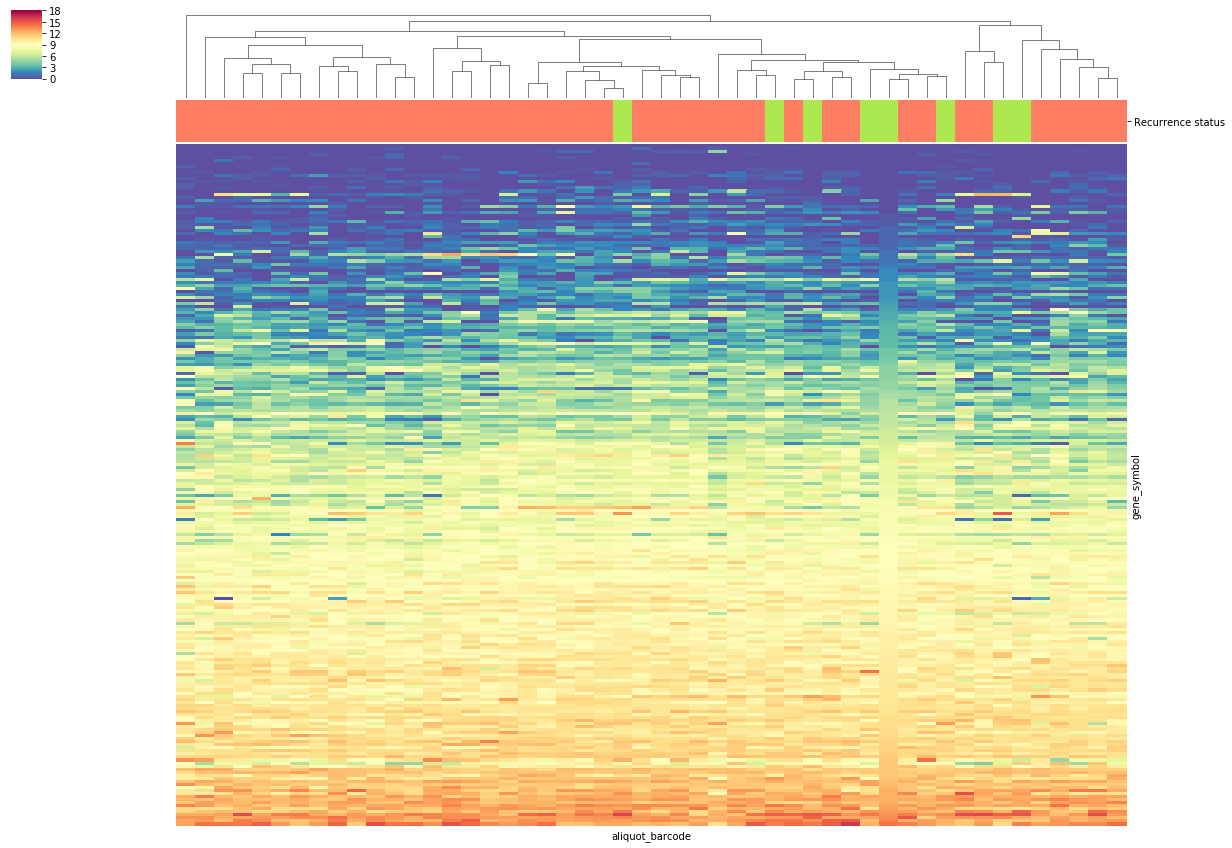

In [20]:
lowrisk_aliquots = recur.loc[(recur['recurrence_status'] == 'Low risk'), 'aliquot_barcode'].unique()

g7 = sns.clustermap(data=expression_matrix.sort_values(by=list(lowrisk_aliquots)), 
                    col_linkage=linkage, row_cluster = False,
                   col_colors = color_matrix,
                   cmap="Spectral_r", vmin=0, vmax=18, figsize=(20,15), 
                   xticklabels=False, yticklabels=False)

In [21]:
g6.savefig("./plots/cluster_expression.hormone.excl_norm.recur.corrdata.png")
g7.savefig("./plots/cluster_expression.hormone.excl_norm.recur.expressiondata.png")

## Complete + Low-risk vs. Progressive/Stable + Relapsed

In [22]:
restricted = hormone_expression_bigtable.loc[(hormone_expression_bigtable['sample_type'] == 1) &
                                             (hormone_expression_bigtable['recurrence_status'] != 'Unknown') & 
                                             (hormone_expression_bigtable['recurrence_status'].isna() == False) & 
                                             (hormone_expression_bigtable['initial_response'] != 'Unknown')]
expression_matrix = restricted.pivot(index='gene_symbol', columns='aliquot_barcode', values='transformed_count')

print(expression_matrix.shape)
expression_matrix.head()

(224, 11)


aliquot_barcode,TCGA-A2-A0EW-01A-21R-A115-07,TCGA-A7-A3RF-01A-11R-A22K-07,TCGA-A8-A08O-01A-21R-A056-07,TCGA-D8-A73W-01A-22R-A352-07,TCGA-E2-A1IE-01A-11R-A13Q-07,TCGA-E9-A1N6-01A-11R-A144-07,TCGA-GM-A2DA-01A-11R-A18M-07,TCGA-GM-A2DC-01A-11R-A18M-07,TCGA-GM-A2DM-01A-11R-A180-07,TCGA-GM-A2DN-01A-11R-A180-07,TCGA-LL-A73Z-01A-11R-A32P-07
gene_symbol,,,,,,,,,,,
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.629566,0.000000,0.000000,0.545079
AATK,4.875254,9.790787,5.202500,8.556529,8.047976,5.249999,4.572968,8.295913,8.713732,6.371308,6.127749
ADRA2C,6.048299,7.731880,3.403309,3.350115,8.306813,4.355961,5.816973,9.217166,1.732313,4.037918,6.362245
ANP32E,9.781118,8.128950,10.356002,9.623196,8.359199,10.063238,9.661606,10.929548,9.665320,10.816003,10.626102
ARHGEF37,10.890471,9.261242,9.870556,9.164260,8.897435,10.430058,9.310825,9.816281,9.523792,9.118826,10.149730


In [23]:
color_matrix = pd.DataFrame()
df = restricted.drop_duplicates(subset="aliquot_barcode")

print(df['initial_response'].unique())
print(df['recurrence_status'].unique())

['Progressive/Stable' 'Complete response']
['Occured' 'Low risk']


In [24]:
pd.crosstab(df['initial_response'], df['recurrence_status'], margins=True)

recurrence_status,Low risk,Occured,All
initial_response,,,
Complete response,3,0,3
Progressive/Stable,0,8,8
All,3,8,11


In [25]:
df['subtype_sub'].value_counts()

LumA      9
Normal    1
LumB      1
Name: subtype_sub, dtype: int64

In [26]:
c = dict(zip(df['initial_response'].unique(), ["#edea3d", "#8cc8e2"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

c = dict(zip(df['recurrence_status'].unique(), ["#ff7e63", "#aee851"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Initial response,Recurrence status
aliquot_barcode,,
TCGA-A2-A0EW-01A-21R-A115-07,#edea3d,#ff7e63
TCGA-A7-A3RF-01A-11R-A22K-07,#edea3d,#ff7e63
TCGA-A8-A08O-01A-21R-A056-07,#edea3d,#ff7e63
TCGA-D8-A73W-01A-22R-A352-07,#edea3d,#ff7e63
TCGA-E2-A1IE-01A-11R-A13Q-07,#edea3d,#ff7e63


In [27]:
distance = scipy.spatial.distance.squareform(1-expression_matrix.corr())
linkage = scipy.cluster.hierarchy.linkage(distance, method='complete')

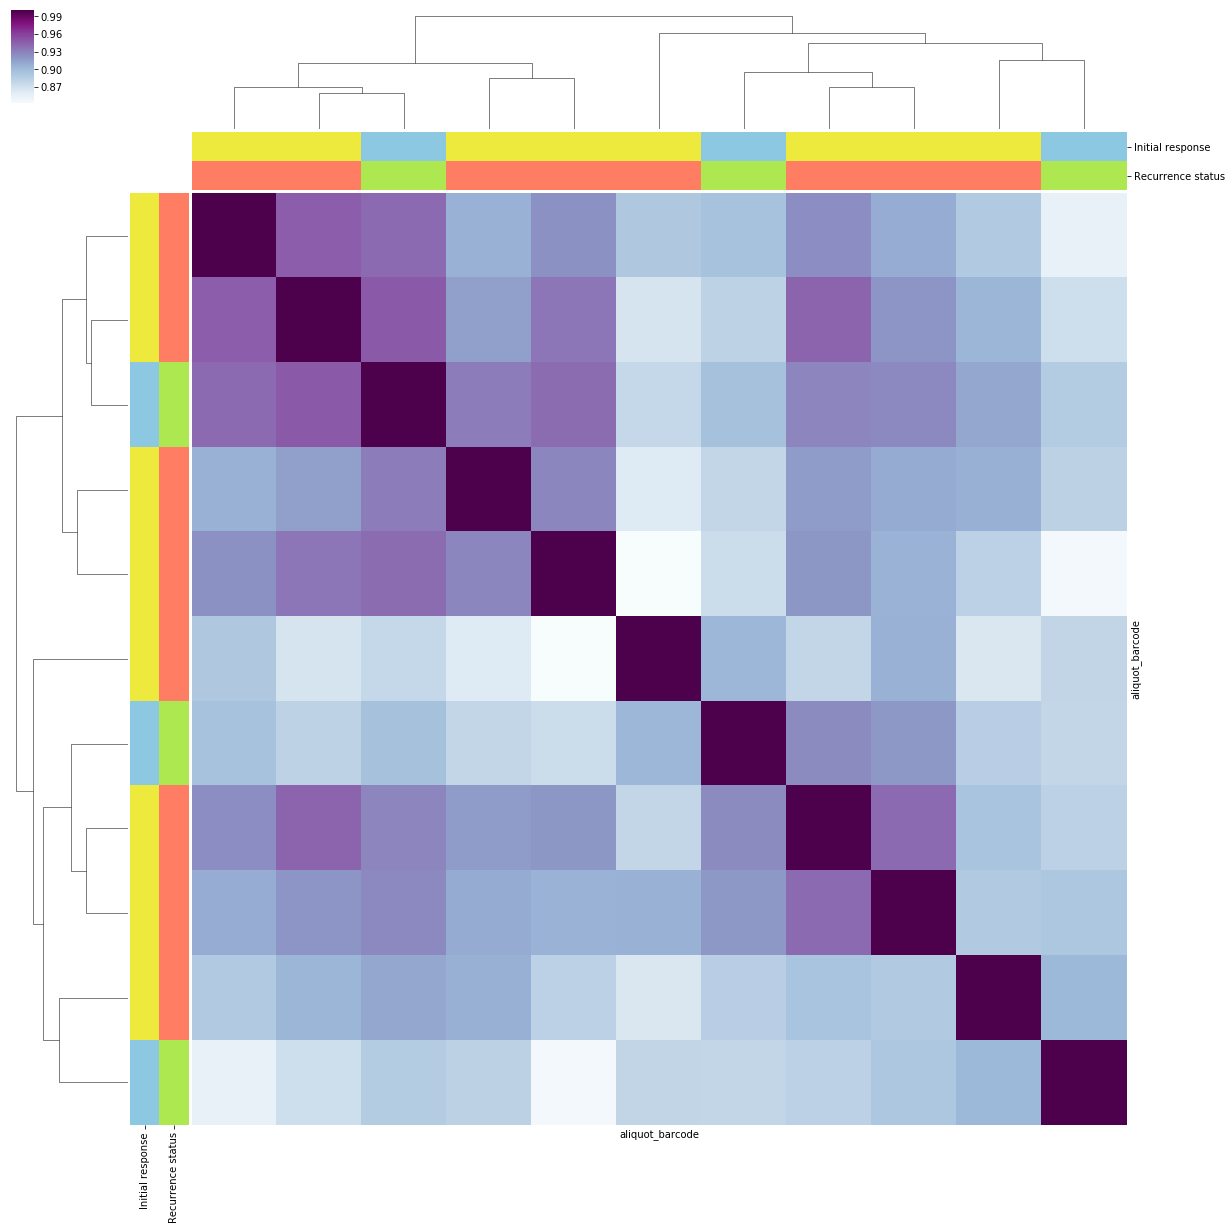

In [28]:
g8 = sns.clustermap(data=expression_matrix.corr(), col_linkage=linkage, row_linkage=linkage,
                   row_colors=color_matrix, col_colors = color_matrix,
                   cmap="BuPu", vmax=1, figsize=(20,20.5), 
                   xticklabels=False, yticklabels=False)

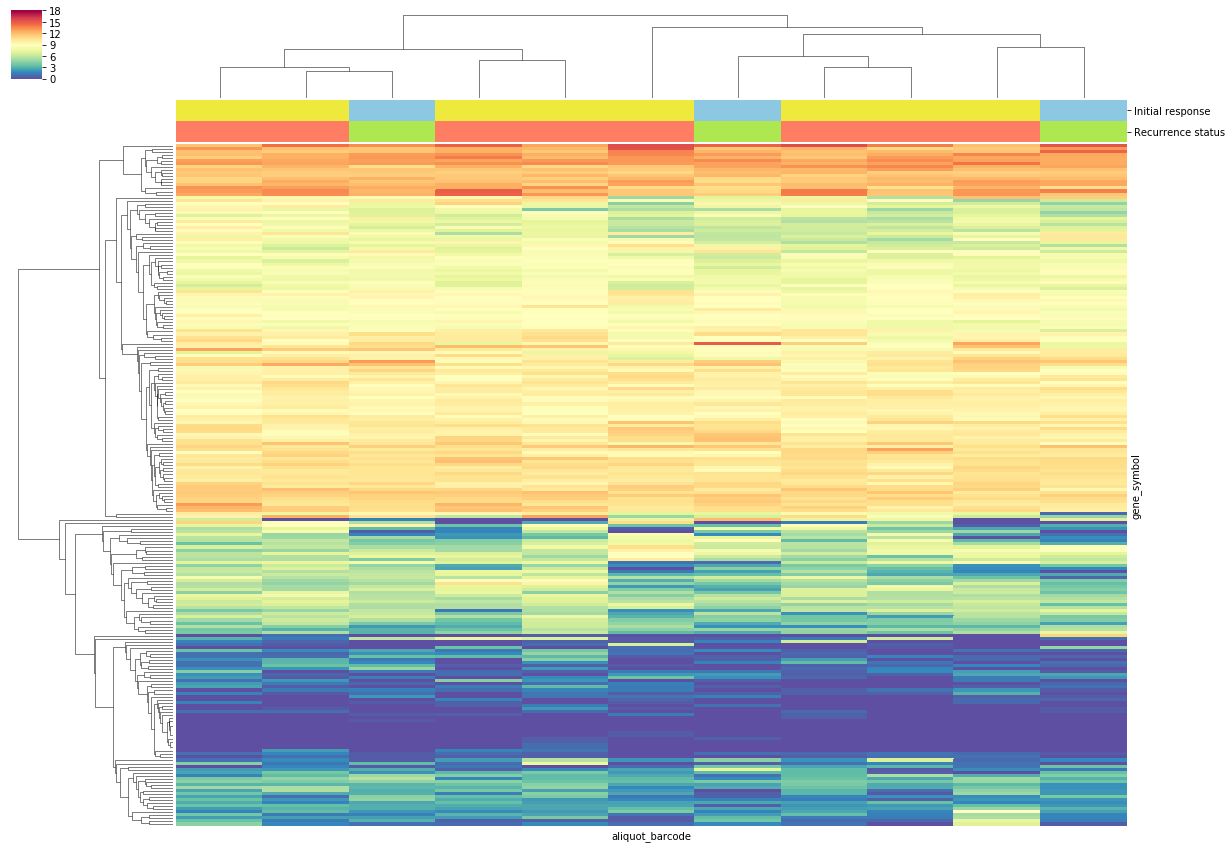

In [29]:
g9 = sns.clustermap(data=expression_matrix, col_linkage=linkage, row_cluster = True,
                   col_colors = color_matrix,
                   cmap="Spectral_r", vmin=0, vmax=18, figsize=(20,15), 
                   xticklabels=False, yticklabels=False)

In [30]:
g8.savefig("./plots/cluster_expression.hormone.excl_norm.init_recur.corrdata.png")
g9.savefig("./plots/cluster_expression.hormone.excl_norm.init_recur.expressiondata.png")

# Normal tissues only

In [31]:
only_normal = hormone_expression_bigtable.loc[hormone_expression_bigtable['sample_type'] == 11]
expression_matrix = only_normal.pivot(index='gene_symbol', columns='aliquot_barcode', values='transformed_count')

print(expression_matrix.shape)
expression_matrix.head()

(224, 33)


aliquot_barcode,TCGA-A7-A0D9-11A-53R-A089-07,TCGA-A7-A0DB-11A-33R-A089-07,TCGA-A7-A0DC-11A-41R-A089-07,TCGA-A7-A13E-11A-61R-A12P-07,TCGA-A7-A13F-11A-42R-A12P-07,TCGA-A7-A13G-11A-51R-A13Q-07,TCGA-AC-A2FB-11A-13R-A17B-07,TCGA-AC-A2FF-11A-13R-A17B-07,TCGA-BH-A0AY-11A-23R-A089-07,TCGA-BH-A0B8-11A-41R-A089-07,...,TCGA-E2-A15I-11A-32R-A137-07,TCGA-E2-A15M-11A-22R-A12D-07,TCGA-E2-A1BC-11A-32R-A12P-07,TCGA-E2-A1IG-11A-22R-A144-07,TCGA-E9-A1N4-11A-33R-A14M-07,TCGA-E9-A1N5-11A-41R-A14D-07,TCGA-E9-A1N6-11A-32R-A144-07,TCGA-E9-A1NA-11A-33R-A144-07,TCGA-E9-A1NF-11A-73R-A14D-07,TCGA-E9-A1NG-11A-52R-A14M-07
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.640528,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.375178,0.000000,0.000000,0.000000,0.000000,0.000000
AATK,4.956089,5.116905,5.842577,5.250973,5.778316,4.300622,5.527430,5.479321,5.357552,4.550057,...,4.038770,6.290024,5.017445,5.570955,5.123521,5.685691,5.467139,5.646834,5.932904,5.610384
ADRA2C,6.329656,6.743967,6.864976,7.144808,6.970193,6.356271,6.366060,4.812837,6.362896,7.268351,...,5.563994,6.956900,7.397868,6.828312,4.808848,3.919521,6.025831,7.216198,6.964089,6.686049
ANP32E,9.166989,9.995184,10.141016,9.352723,9.274543,9.842412,10.110755,10.216136,10.049434,9.778098,...,10.063120,9.904411,9.728791,9.761114,10.287002,10.471928,10.118482,9.656397,9.802101,9.977503
ARHGEF37,9.340181,8.721557,10.166392,9.896904,10.561815,8.236152,10.528211,10.764418,10.049434,9.144538,...,9.064468,10.070318,8.337417,10.359237,11.487103,10.309289,10.781128,10.357784,8.928484,9.056112


In [32]:
expression_matrix.corr().min().min()

0.833752613864552

In [33]:
color_matrix = pd.DataFrame()
df = only_normal.drop_duplicates(subset="aliquot_barcode")

print(df['initial_response'].unique())
print(df['recurrence_status'].unique())

['Unknown' 'Complete response' 'Progressive/Stable']
['Unknown' 'Occured']


In [34]:
c = dict(zip(df['initial_response'].unique(), ["#ffffff", "#8cc8e2", "#edea3d"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

c = dict(zip(df['recurrence_status'].unique(), ["#ffffff", "#ff7e63"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Initial response,Recurrence status
aliquot_barcode,,
TCGA-A7-A0D9-11A-53R-A089-07,#ffffff,#ffffff
TCGA-A7-A0DB-11A-33R-A089-07,#ffffff,#ffffff
TCGA-A7-A0DC-11A-41R-A089-07,#ffffff,#ffffff
TCGA-A7-A13E-11A-61R-A12P-07,#ffffff,#ff7e63
TCGA-A7-A13F-11A-42R-A12P-07,#ffffff,#ffffff


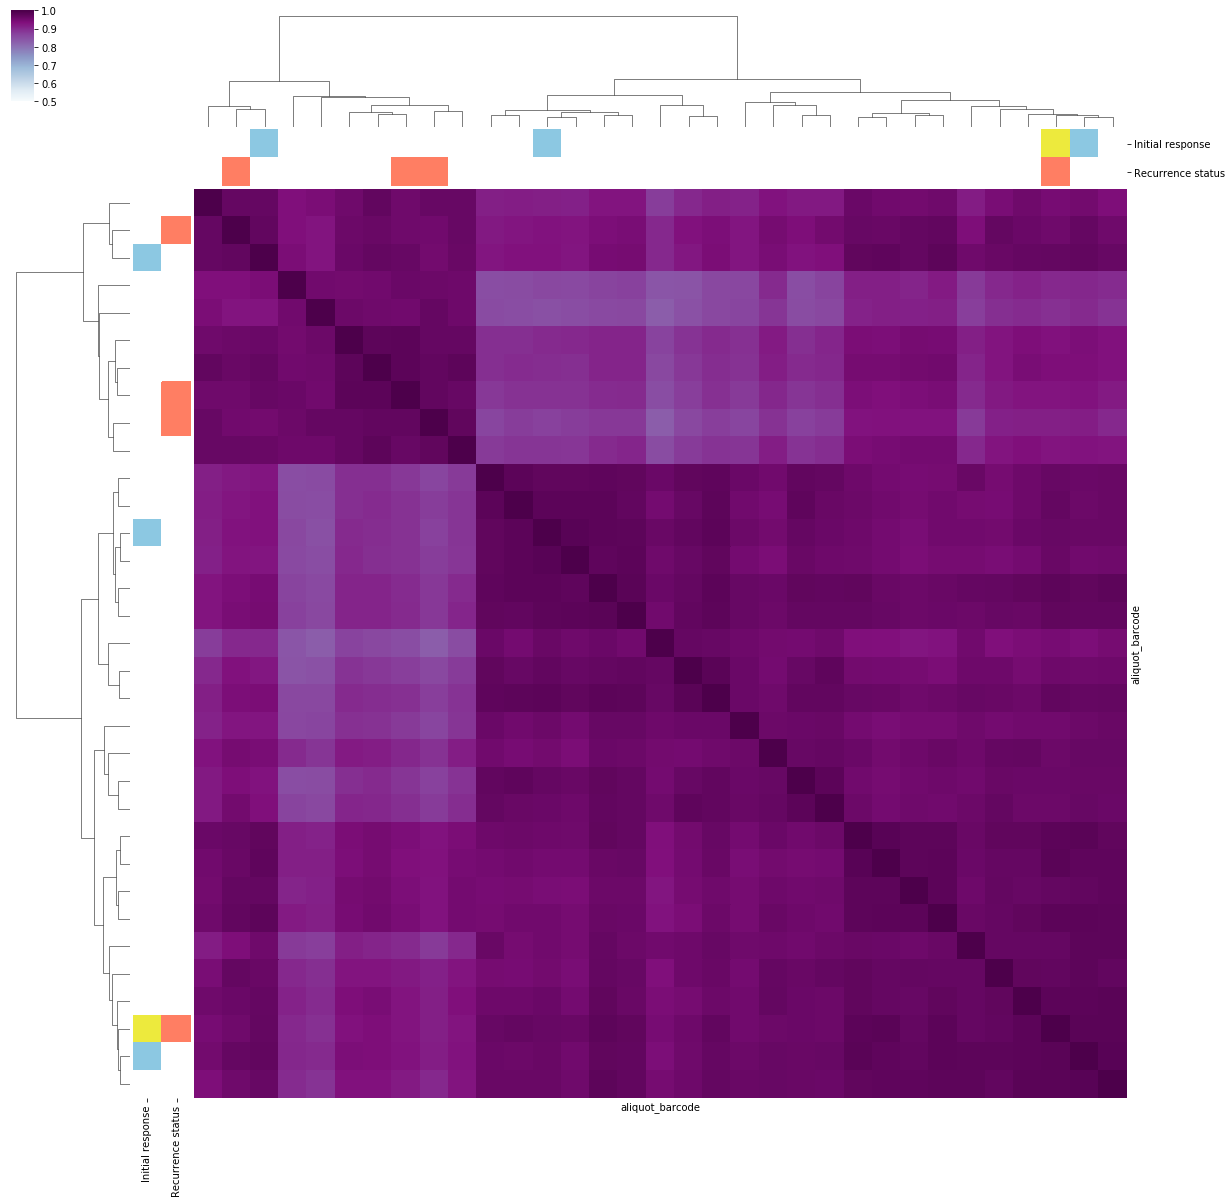

In [35]:
distance = scipy.spatial.distance.squareform(1-expression_matrix.corr())
linkage = scipy.cluster.hierarchy.linkage(distance, method='complete')

gg = sns.clustermap(data=expression_matrix.corr(), col_linkage=linkage, row_linkage=linkage,
                   row_colors=color_matrix, col_colors = color_matrix,
                   cmap="BuPu", vmin=0.5, vmax=1, figsize=(20,20), 
                   xticklabels=False, yticklabels=False)